Num GPUs Available:  0
Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


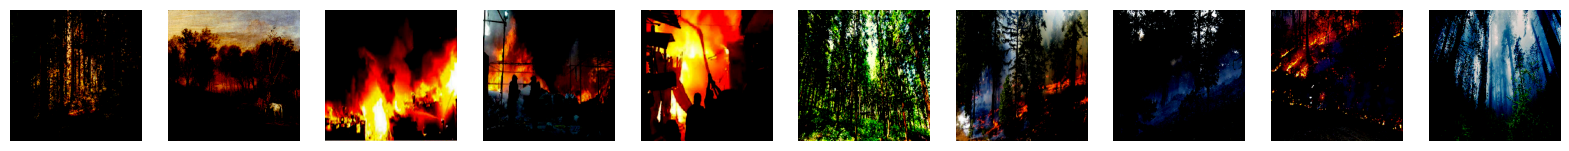

Epoch 1/10


/home/jinho/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 - 5s - 153ms/step - accuracy: 0.8000 - loss: 0.5381 - val_accuracy: 0.9125 - val_loss: 0.2769
Epoch 2/10
32/32 - 4s - 132ms/step - accuracy: 0.8844 - loss: 0.2308 - val_accuracy: 0.9250 - val_loss: 0.1580
Epoch 3/10
32/32 - 4s - 132ms/step - accuracy: 0.9625 - loss: 0.1143 - val_accuracy: 0.8750 - val_loss: 0.2970
Epoch 4/10
32/32 - 4s - 136ms/step - accuracy: 0.9594 - loss: 0.1129 - val_accuracy: 0.9250 - val_loss: 0.1538
Epoch 5/10
32/32 - 4s - 134ms/step - accuracy: 0.9781 - loss: 0.0688 - val_accuracy: 0.9125 - val_loss: 0.2356
Epoch 6/10
32/32 - 4s - 135ms/step - accuracy: 0.9937 - loss: 0.0500 - val_accuracy: 0.9375 - val_loss: 0.1635
Epoch 7/10
32/32 - 4s - 131ms/step - accuracy: 0.9937 - loss: 0.0280 - val_accuracy: 0.9375 - val_loss: 0.1558
Epoch 8/10
32/32 - 4s - 134ms/step - accuracy: 1.0000 - loss: 0.0207 - val_accuracy: 0.9250 - val_loss: 0.1539
Epoch 9/10
32/32 - 5s - 142ms/step - accuracy: 1.0000 - loss: 0.0147 - val_accuracy: 0.9375 - val_loss: 0.1482
Epoch 10/10


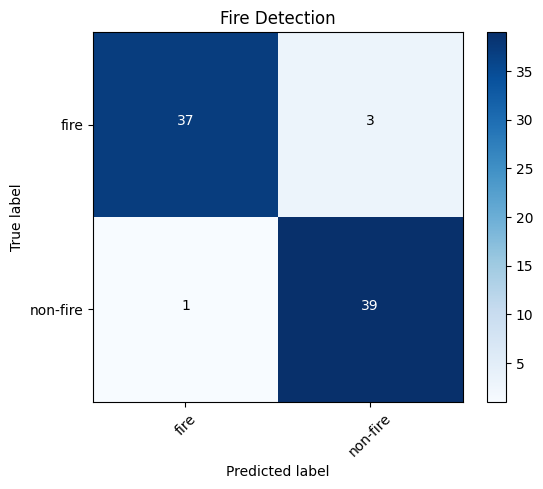

In [3]:
import time, os, shutil, random, glob, warnings
import tensorflow as tf
from functions import plot_confusion_matrix, plotImages
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix

# Measure the time taken
start_time = time.time()
warnings.simplefilter(action='ignore', category=FutureWarning)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

# tf.config.experimental.set_memory_growth(physical_devices[0], True)
# Doesn't work on native Windows with tensorflow > V 2.10

# Organize data into train, valid, test dirs
# ---------------------------------------------------------------------------------------------------
os.chdir('data/fire-vs-non_fire')

# Check if the directory is already exists first
if os.path.isdir('train/fire') is False:
    os.makedirs('train/fire')
    os.makedirs('train/non_fire')
    os.makedirs('valid/fire')
    os.makedirs('valid/non_fire')
    os.makedirs('test/fire')
    os.makedirs('test/non_fire')

    # There are 480 images. fire(240) & non_fire(240)
    # Train : Valid : Test = 8 : 2 : 2
    # Train: 320 (160, 160)
    # Valid: 80 (40, 40)
    # Test: 80 (40, 40)
    for c in random.sample(glob.glob('fire*'), 160):
        shutil.move(c, 'train/fire')
    for c in random.sample(glob.glob('non_fire*'), 160):
        shutil.move(c, 'train/non_fire')
    for c in random.sample(glob.glob('fire*'), 40):
        shutil.move(c, 'valid/fire')
    for c in random.sample(glob.glob('non_fire*'), 40):
        shutil.move(c, 'valid/non_fire')
    for c in random.sample(glob.glob('fire*'), 40):
        shutil.move(c, 'test/fire')
    for c in random.sample(glob.glob('non_fire*'), 40):
        shutil.move(c, 'test/non_fire')

os.chdir('../../')

# Path to the different dataset directories
# ---------------------------------------------------------------------------------------------------
train_path = 'data/fire-vs-non_fire/train'
valid_path = 'data/fire-vs-non_fire/valid'
test_path = 'data/fire-vs-non_fire/test'

# Directory iterator
train_batches = ImageDataGenerator(preprocessing_function=
    tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224, 224),  batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=
    tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224, 224),  batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=
    tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224, 224),  batch_size=10, shuffle=False)

# Checks if datasets are accurate
assert train_batches.n == 320
assert valid_batches.n == 80
assert test_batches.n == 80
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

# Displays some images in train directory after they are pre-processed
# ---------------------------------------------------------------------------------------------------
imgs, labels = next(train_batches)
print(labels)  
plotImages(imgs)

# Fine tuning our CNN to work with our dataset and starting the training
# ---------------------------------------------------------------------------------------------------
mobile = MobileNetV2()
# mobile.summary()   # This line was to show the layers of our CNN

x = mobile.layers[0].output
output = Flatten()(x)
output = Dense(units=2, activation = 'sigmoid')(output)
model = Model(inputs=mobile.input, outputs = output)
tf.keras.optimizers.Adam()
model.compile(optimizer = Adam(learning_rate=0.0001), 
              loss = 'binary_crossentropy', metrics =['accuracy'])
model.fit(train_batches, validation_data=valid_batches, epochs=10, verbose = 2)

# Preparing data to be tested and then making a confusion matrix with the results
# ---------------------------------------------------------------------------------------------------
test_labels = test_batches.classes
predicitons = model.predict(x=test_batches, verbose =0)
cm = confusion_matrix(y_true = test_labels, y_pred=predicitons.argmax(axis=1))
test_batches.class_indices
cm_plot_labels = ['fire', 'non-fire']

# Outputting total time, confusion matrix, and accuracies 
# ---------------------------------------------------------------------------------------------------
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: {:.2f} seconds".format(elapsed_time))
plot_confusion_matrix(cm=cm, classes =cm_plot_labels, title = 'Fire Detection')